In [1]:
#@title
#from google.colab import drive
#drive.mount("/content/gdrive")

import matplotlib
import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import geoplot as gplt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

In [2]:
#@title
africa = pd.read_csv('C://Users/Ewan/Downloads/GTD_ACLED_Africa.csv') #This is disaggregated data on terror attacks in Africa.

In [ ]:
#Restrict to Boko Haram
boko_haram = africa[africa['gname'].str.contains('boko haram', case=False)] #Filter for events due to Boko Haram 
boko_haram.date = pd.to_datetime(boko_haram.date)
boko_haram.sort_values(by='date', inplace=True)
boko_haram = boko_haram[boko_haram.date.dt.year>2009] #There is a large event occuring in 2009 which I want to remove as it seems like an outlier
boko_haram = boko_haram.iloc[:,1:].reset_index(drop=True)
#boko_haram.to_csv('/content/gdrive/My Drive/GTD/Data/boko_haram.csv')


In [0]:
#boko_haram = pd.read_csv('/content/gdrive/My Drive/GTD/Data/boko_haram.csv')

In [5]:
#This section is for creating the map plot. In order to not confuse the later parts I'm using bh not boko_haram in this part.

bh = boko_haram

def myround(x, prec=4, base=0.0145): #This base is chosen as it is roughly 1 square mile at the equator
  return round(base * round(float(x)/base),prec)

bh['lat_rounded'] = bh['latitude'].apply(myround)
bh['long_rounded'] = bh['longitude'].apply(myround)

bh['date'] = pd.to_datetime(bh.date)
bh['year'] = bh['date'].dt.year

bh_pixelated_yearly = bh.loc[:,['year', 'long_rounded', 'lat_rounded', 'is_urban']].groupby(by=['year', 'long_rounded', 'lat_rounded']).apply(np.mean)
bh_pixelated_yearly = bh_pixelated_yearly.loc[:, ['is_urban']].reset_index()

polys = gpd.read_file('C://Users/Ewan/Downloads/Africa_SHP')

polys_bh = polys[polys.COUNTRY.isin(np.unique(bh['country_txt']))]

In [6]:
#These functions get the proportion of events in a dataset that occurred in urban areas and the number of events for use in plotting cartograms

def get_prop_urban(country, min_year, max_year):
    df = boko_haram[boko_haram['country_txt'] == country][boko_haram['year'] >= min_year][boko_haram['year'] <= max_year]
    prop_urban = df['is_urban'].mean()
    return prop_urban

def get_event_count(country, min_year, max_year):
    df = boko_haram[boko_haram['country_txt'] == country][boko_haram['year'] >= min_year][boko_haram['year'] <= max_year]
    event_count = len(df)
    return event_count

The purpose of this research is to investigate how the behaviour of Boko Haram has changed over time, specifically regarding their preference for rural or urban targets. For each event we determine whether it is urban or rural by checking whether its coordinates lie inside any city polygon in Africa, with the city polygon data provided by Africapolis.

In the paper Strategic Risk of Terrorist Targets in Urban vs. Rural Locations, Hinkkainen and Pickering demonstrate the importance of understanding the differences of terrorism in urban and rural areas from the perspective of risk assessment for different target types. For example, identifying the risk to civilian, governmental and police targets in urban and rural areas differently. It follows that any statistical model used in the evaluation of risk must differentiate between urban and rural areas effectively. For this reason it is important to have effective and practical methods of identifying locations as urban or rural, such as the approach outlined in this article.

Let's take a look at the geographical distribution of terror events attributed to Boko Haram and see how things have developed over the years. Points range in colour from yellow to red, yellow meaning a rural event, and red meaning urban. The data is aggregated into specified time intervals and spatial pixels, with a pixel being roughly a square mile so that each point may represent multiple events with the colour representing the proportion of events that were urban. We see a clear shift to rural areas and a movement to North-East Nigeria and the bordering areas.

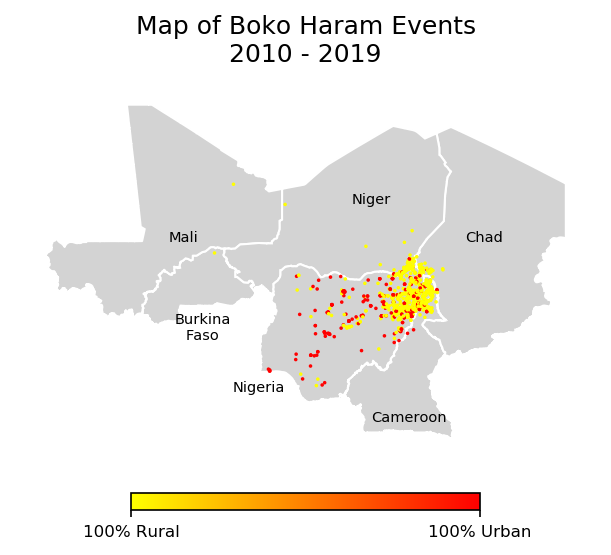

In [20]:
fig, ax = plt.subplots(figsize=(5,5), dpi=150)

current_cmap = matplotlib.cm.get_cmap('autumn_r')

s = ax.scatter(bh_pixelated_yearly['long_rounded'],
                  bh_pixelated_yearly['lat_rounded'],
                  c = bh_pixelated_yearly['is_urban'],
                  cmap = 'autumn_r', s=0.5, alpha=1)
gplt.polyplot(polys_bh, facecolor='lightgray', edgecolor='white', ax=ax)
plt.title('Map of Boko Haram Events\n2010 - 2019')

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=current_cmap), ax=ax, cmap=current_cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=1), orientation='horizontal', shrink=0.6, fraction=0.046, pad=0.04, ticks=[0,1])

cbar.ax.set_xticklabels(['100% Rural', '100% Urban'], fontsize=8)

plt.figtext(0.35, 0.5, 'Mali', ha='center', va='center', fontsize=7)
plt.figtext(0.375, 0.38, 'Burkina\nFaso', ha='center', va='center', fontsize=7)
plt.figtext(0.45, 0.3, 'Nigeria', ha='center', va='center', fontsize=7)
plt.figtext(0.65, 0.26, 'Cameroon', ha='center', va='center', fontsize=7)
plt.figtext(0.6, 0.55, 'Niger', ha='center', va='center', fontsize=7)
plt.figtext(0.75, 0.5, 'Chad', ha='center', va='center', fontsize=7)

plt.show()

In [ ]:
#Separate into different time periods for plotting sparately

bh_pixelated1 = bh_pixelated_yearly[bh_pixelated_yearly['year'] >= 2010][bh_pixelated_yearly['year'] <= 2013]
bh_pixelated2 = bh_pixelated_yearly[bh_pixelated_yearly['year'] >= 2014][bh_pixelated_yearly['year'] <= 2017]
bh_pixelated3 = bh_pixelated_yearly[bh_pixelated_yearly['year'] == 2018]
bh_pixelated4 = bh_pixelated_yearly[bh_pixelated_yearly['year'] == 2019]

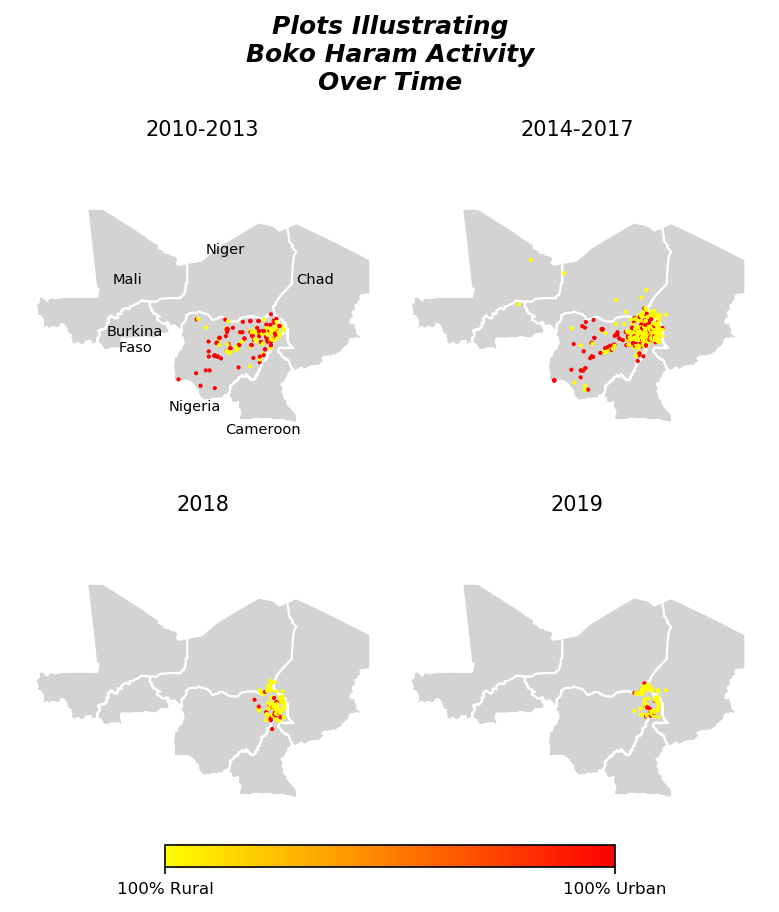

In [22]:
import matplotlib

current_cmap = matplotlib.cm.get_cmap('autumn_r')
#current_cmap.set_under(color='lightgray')
#current_cmap.autoscale()

fig, ax = plt.subplots(figsize=(5,5), dpi=150)
#plt.suptitle('Plots Illustrating Shift of Events from\nUrban Areas to Rural Areas', fontsize=12, style='oblique', weight='bold')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.figtext(0.5, 1.1, 'Plots Illustrating\nBoko Haram Activity\nOver Time', ha='center', va='center', fontsize=12, style='oblique', weight='bold')

ax1 = plt.subplot(2, 2, 1)
s1 = ax1.scatter(bh_pixelated1['long_rounded'],
                  bh_pixelated1['lat_rounded'],
                  c = bh_pixelated1['is_urban'],
                  cmap = 'autumn_r', s=1, alpha=1)
gplt.polyplot(polys_bh, facecolor='lightgray', edgecolor='white', ax=ax1)
plt.figtext(0.25, 1, '2010-2013', fontsize=10, ha='center', va='center')

ax2 = plt.subplot(2, 2, 2)
s2 = ax2.scatter(bh_pixelated2['long_rounded'],
                  bh_pixelated2['lat_rounded'],
                  c = bh_pixelated2['is_urban'],
                  cmap = 'autumn_r', s=1, alpha=1)
gplt.polyplot(polys_bh, facecolor='lightgray', edgecolor='white', ax=ax2)
plt.figtext(0.75, 1, '2014-2017', fontsize=10, ha='center', va='center')

ax3 = plt.subplot(2, 2, 3)
s3 = ax3.scatter(bh_pixelated3['long_rounded'],
                  bh_pixelated3['lat_rounded'],
                  c = bh_pixelated3['is_urban'],
                  cmap = 'autumn_r', s=1, alpha=1)
gplt.polyplot(polys_bh, facecolor='lightgray', edgecolor='white', ax=ax3)
plt.figtext(0.25, 0.5, '2018', fontsize=10, ha='center', va='center')

ax4 = plt.subplot(2, 2, 4)
s4 = ax4.scatter(bh_pixelated4['long_rounded'],
                  bh_pixelated4['lat_rounded'],
                  c = bh_pixelated4['is_urban'],
                  cmap = 'autumn_r', s=1, alpha=1)
gplt.polyplot(polys_bh, facecolor='lightgray', edgecolor='white', ax=ax4)
plt.figtext(0.75, 0.5, '2019', fontsize=10, ha='center', va='center')

plt.figtext(0.15, 0.8, 'Mali', ha='center', va='center', fontsize=7)
plt.figtext(0.16, 0.72, 'Burkina\nFaso', ha='center', va='center', fontsize=7)
plt.figtext(0.24, 0.63, 'Nigeria', ha='center', va='center', fontsize=7)
plt.figtext(0.33, 0.6, 'Cameroon', ha='center', va='center', fontsize=7)
plt.figtext(0.28, 0.84, 'Niger', ha='center', va='center', fontsize=7)
plt.figtext(0.4, 0.8, 'Chad', ha='center', va='center', fontsize=7)


cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=current_cmap), ax=ax, cmap=current_cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=1), orientation='horizontal', shrink=0.6, fraction=0.046, pad=0.04, ticks=[0,1])

cbar.ax.set_xticklabels(['100% Rural', '100% Urban'], fontsize=8)
plt.show()
fig.savefig('Boko_Haram_Scatter.jpg', bbox_inches='tight',dpi=100)

If we aggregate by country and plot a cartogram of events we get the following. Here the size scaling of a country indicates the proportion of events occurring in that country relative to the other countries.

In [23]:
import warnings; warnings.simplefilter('ignore')

#This does the same but for plotting cartograms

polys_for_plot1 = polys_bh.assign(prop_urban = polys_bh['COUNTRY'].apply(get_prop_urban, min_year=2010, max_year=2013))
polys_for_plot1 = polys_for_plot1.assign(event_count = polys['COUNTRY'].apply(get_event_count, min_year=2010, max_year=2013))
polys_for_plot1 = polys_for_plot1.dropna(subset=['prop_urban'])
polys_for_plot1 = polys_for_plot1[polys_for_plot1['event_count']>0]
polys_for_plot1 = polys_for_plot1.append(polys_for_plot1.iloc[[0,0],:], ignore_index=True)
polys_for_plot1.loc[np.shape(polys_for_plot1)[0]-1, ['prop_urban']] = 1
polys_for_plot1.loc[np.shape(polys_for_plot1)[0]-2, ['prop_urban']] = 0

polys_for_plot2 = polys_bh.assign(prop_urban = polys_bh['COUNTRY'].apply(get_prop_urban, min_year=2014, max_year=2017))
polys_for_plot2 = polys_for_plot2.assign(event_count = polys['COUNTRY'].apply(get_event_count, min_year=2014, max_year=2017))
polys_for_plot2 = polys_for_plot2.dropna(subset=['prop_urban'])
polys_for_plot2 = polys_for_plot2[polys_for_plot2['event_count']>0]
polys_for_plot2 = polys_for_plot2.append(polys_for_plot2.iloc[[0,0],:], ignore_index=True)
polys_for_plot2.loc[np.shape(polys_for_plot2)[0]-1, ['prop_urban']] = 1
polys_for_plot2.loc[np.shape(polys_for_plot2)[0]-2, ['prop_urban']] = 0

polys_for_plot3 = polys_bh.assign(prop_urban = polys_bh['COUNTRY'].apply(get_prop_urban, min_year=2018, max_year=2018))
polys_for_plot3 = polys_for_plot3.assign(event_count = polys['COUNTRY'].apply(get_event_count, min_year=2018, max_year=2018))
polys_for_plot3 = polys_for_plot3.dropna(subset=['prop_urban'])
polys_for_plot3 = polys_for_plot3[polys_for_plot3['event_count']>0]
polys_for_plot3 = polys_for_plot3.append(polys_for_plot3.iloc[[0,0],:], ignore_index=True)
polys_for_plot3.loc[np.shape(polys_for_plot3)[0]-1, ['prop_urban']] = 1
polys_for_plot3.loc[np.shape(polys_for_plot3)[0]-2, ['prop_urban']] = 0

polys_for_plot4 = polys_bh.assign(prop_urban = polys_bh['COUNTRY'].apply(get_prop_urban, min_year=2019, max_year=2019))
polys_for_plot4 = polys_for_plot4.assign(event_count = polys['COUNTRY'].apply(get_event_count, min_year=2019, max_year=2019))
polys_for_plot4 = polys_for_plot4.dropna(subset=['prop_urban'])
polys_for_plot4 = polys_for_plot4[polys_for_plot4['event_count']>0]
polys_for_plot4 = polys_for_plot4.append(polys_for_plot4.iloc[[0,0],:], ignore_index=True)
polys_for_plot4.loc[np.shape(polys_for_plot4)[0]-1, ['prop_urban']] = 1
polys_for_plot4.loc[np.shape(polys_for_plot4)[0]-2, ['prop_urban']] = 0

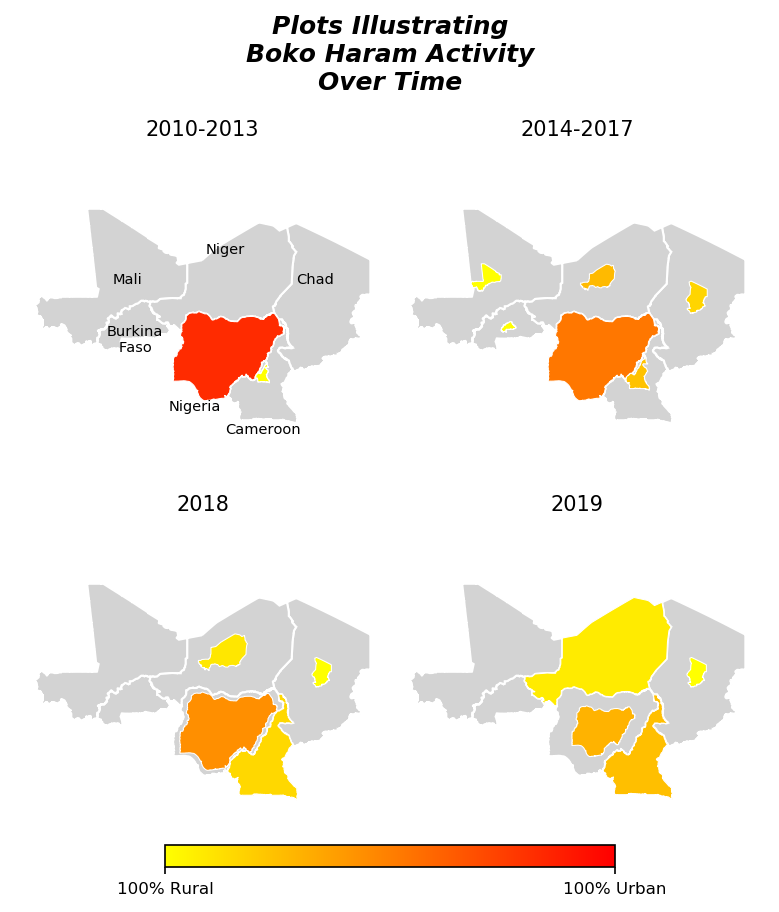

In [24]:
import matplotlib

current_cmap = matplotlib.cm.get_cmap('autumn_r')
#current_cmap.set_under(color='lightgray')
#current_cmap.autoscale()

fig, ax = plt.subplots(figsize=(5,5), dpi=150)
#plt.suptitle('Plots Illustrating Shift of Events from\nUrban Areas to Rural Areas', fontsize=12, style='oblique', weight='bold')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.figtext(0.5, 1.1, 'Plots Illustrating\nBoko Haram Activity\nOver Time', ha='center', va='center', fontsize=12, style='oblique', weight='bold')

ax1 = plt.subplot(2, 2, 1)
gplt.cartogram(polys_for_plot1, scale='event_count', hue='prop_urban', cmap=current_cmap, linewidth=0.5, edgecolor='white', k=None, ax=ax1)        
#plt.title('2010-2014', fontsize=10)
plt.figtext(0.25, 1, '2010-2013', fontsize=10, ha='center', va='center')
gplt.polyplot(polys_bh, facecolor='lightgray', edgecolor='white', ax=ax1)

ax2 = plt.subplot(2, 2, 2)
gplt.cartogram(polys_for_plot2, scale='event_count', hue='prop_urban', cmap=current_cmap, linewidth=0.5, edgecolor='white', k=None, ax=ax2)        
#plt.title('2015-2017', fontsize=10)
plt.figtext(0.75, 1, '2014-2017', fontsize=10, ha='center', va='center')
gplt.polyplot(polys_bh, facecolor='lightgray', edgecolor='white', ax=ax2)

ax3 = plt.subplot(2, 2, 3)
gplt.cartogram(polys_for_plot3, scale='event_count', hue='prop_urban', cmap=current_cmap, linewidth=0.5, edgecolor='white', k=None, ax=ax3)        
#plt.title('2018', fontsize=10)
plt.figtext(0.25, 0.5, '2018', fontsize=10, ha='center', va='center')
gplt.polyplot(polys_bh, facecolor='lightgray', edgecolor='white', ax=ax3)

ax4 = plt.subplot(2, 2, 4)
gplt.cartogram(polys_for_plot4, scale='event_count', hue='prop_urban', cmap=current_cmap, linewidth=0.5, edgecolor='white', k=None, ax=ax4)        
#plt.title('2019', fontsize=10)
plt.figtext(0.75, 0.5, '2019', fontsize=10, ha='center', va='center')
gplt.polyplot(polys_bh, facecolor='lightgray', edgecolor='white', ax=ax4)

plt.figtext(0.15, 0.8, 'Mali', ha='center', va='center', fontsize=7)
plt.figtext(0.16, 0.72, 'Burkina\nFaso', ha='center', va='center', fontsize=7)
plt.figtext(0.24, 0.63, 'Nigeria', ha='center', va='center', fontsize=7)
plt.figtext(0.33, 0.6, 'Cameroon', ha='center', va='center', fontsize=7)
plt.figtext(0.28, 0.84, 'Niger', ha='center', va='center', fontsize=7)
plt.figtext(0.4, 0.8, 'Chad', ha='center', va='center', fontsize=7)


cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=current_cmap), ax=ax, cmap=current_cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=1), orientation='horizontal', shrink=0.6, fraction=0.046, pad=0.04, ticks=[0,1])

cbar.ax.set_xticklabels(['100% Rural', '100% Urban'], fontsize=8)
plt.show()
#fig.savefig('Boko_Haram_Cartogram1.jpg', bbox_inches='tight',dpi=5000)

Now let's look at the plots of the cumulative sums of number of fatalities and also the number of events due to Boko Haram between 2010 (this is to remove the outlier that occurs a year prior to anything else) and the end of the data, the end of July, 2019. When analysing these plots we're looking at two key features; break points in the curves and the gradients of the linear pieces. A break point is a point in time where there is a distinct change in the gradient of a curve. The gradient of a curve is the rate at which the curve is increasing, a measure of the steepness of the line. In our case this estimates the average number of fatalities/events per day. This will be done by fitting a piecewise linear function to the curve.

In [4]:
#@title
boko_haram['ones'] = 1 #Introducing a ones column to sum and give the number of events in a given day.
boko_haram_grouped_by_day = boko_haram.groupby(['date'])
boko_haram_by_day = boko_haram_grouped_by_day.sum() #This gives us a count for the number of fatalities and number of events

In [5]:
df = boko_haram_by_day.loc[:,['nkill', 'ones']]
df_cum = df.cumsum()

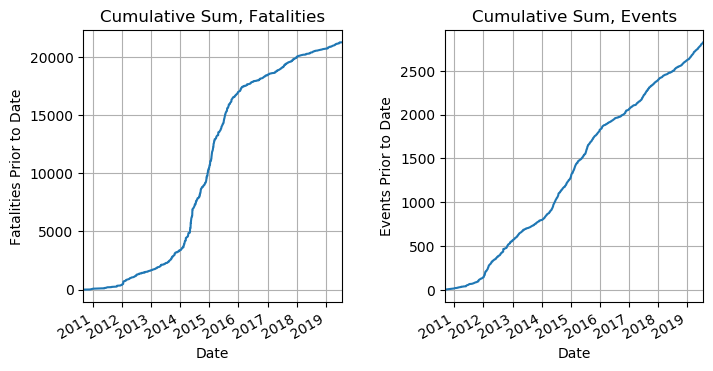

In [7]:
fig, ax = plt.subplots(figsize=(8,4), sharey = True, dpi=100)
plt.subplots_adjust(wspace=0.4)

ax1 = plt.subplot(1,2,1)
_ = df_cum.plot(y='nkill', ax=ax1)
_ = plt.grid()
_ = plt.title('Cumulative Sum, Fatalities')
_ = plt.xlabel('Date')
_ = plt.ylabel('Fatalities Prior to Date')
_ = ax1.get_legend().remove()

ax2 = plt.subplot(1,2,2)
_ = df_cum.plot(y='ones', ax=ax2)
_ = plt.grid()
_ = plt.title('Cumulative Sum, Events')
_ = plt.xlabel('Date')
_ = plt.ylabel('Events Prior to Date')
_ = ax2.get_legend().remove()

plt.show()

Above we see that the graph for fatalities seems to have two distinct break points, however the graph for events is very linear. I will fit a piecewise linear function to the curve for fatalities to see where the break points occur. For this I will implement the pwlf library which uses global optimisation techniques to minimise the mean squared error for a piecewise linear function with a specified number of break points. In order to find a the optimal number of break points we can measure how well the piecewise linear function fits the curve and see where we get little/no improvement. For this we will use the r_squared value provided by the library, a value close to 1 indicates a good fit.

In [8]:
#@title
#!pip install pwlf
import pwlf

In [9]:
def get_r_square(col, number_of_lines):
    my_pwlf = pwlf.PiecewiseLinFit(col.reset_index().index, col)
    breaks = my_pwlf.fitfast(number_of_lines)
    return my_pwlf.r_squared()

def get_regression_table(df, col, number_of_lines):
    my_pwlf = pwlf.PiecewiseLinFit(col.reset_index().index, col)
    breaks = my_pwlf.fitfast(number_of_lines)
    p_values = my_pwlf.p_values()
    r_squared = my_pwlf.r_squared()
    se = my_pwlf.se
    breaks = df.reset_index().loc[np.round(breaks),['date']]
    breaks = pd.Series(breaks.date.values).dt.strftime('%Y-%m-%d')
    regression_table = pd.DataFrame({'Dates': breaks,
                                    'p_values': p_values,
                                    'Standard Error': se})
    return regression_table, 'R_squared: '+str(r_squared)

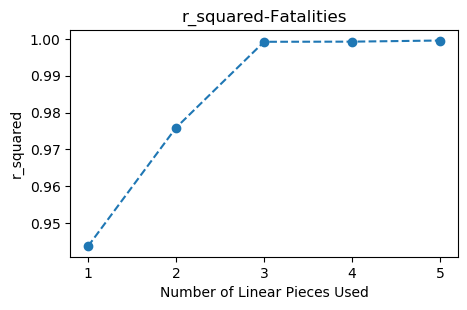

In [28]:
from sklearn.linear_model import LinearRegression

x = np.array(df_cum.reset_index().index).reshape(-1,1)
y = df_cum['nkill']

linear_model = LinearRegression()
_ = linear_model.fit(x, y)
linear_r_sq = linear_model.score(x, y)

r_squared = [get_r_square(df_cum.nkill, number_of_lines) for number_of_lines in (2,3,4,5)]

r_squared = np.append(linear_r_sq, r_squared)

fig, ax = plt.subplots(figsize=(5,3), dpi=100)
_ = plt.plot(np.array([1,2,3,4,5]), r_squared, linestyle='dashed', marker='o')
_ = plt.xticks([1,2,3,4,5])
_ = plt.xlabel('Number of Linear Pieces Used')
_ = plt.ylabel('r_squared')
_ = plt.title('r_squared-Fatalities')

plt.show()

So above we see that 3 linear pieces is indeed the correct number to fit this curve. Let's see where the break points are and plot the curve with the piecewise linear function fitted.

Break points for 3 lines:


,Break Points
0.0,2010-09-05
385.0,2013-10-24
824.0,2015-10-28
1466.0,2019-07-19


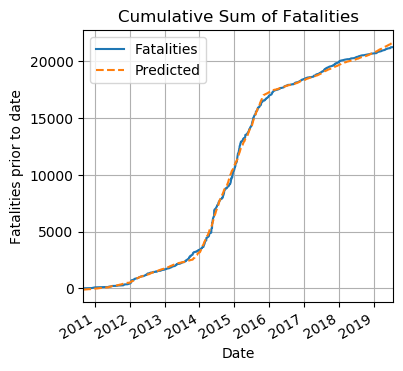

In [29]:
#@title
#Fitting peicewise linear function to cumulative distribution function of nkill

my_pwlf = pwlf.PiecewiseLinFit(df_cum.reset_index().index, df_cum.nkill)

print('Break points for 3 lines:')
breaks = my_pwlf.fit(3)
breaks_nkill = df_cum.reset_index().loc[np.round(breaks),['date']] #This gives us the estimates of the breakpoints
breaks_nkill.columns = ['Break Points']
breaks_nkill

x = df_cum.index.values #x is the dates
df_cum['predicted'] = my_pwlf.predict(range(len(x))) #y is the prediction

fig, ax = plt.subplots(figsize=(4,4), dpi=100)
_ = df_cum.plot(y='nkill', label='Fatalities', ax=ax)
_ = df_cum.plot(y='predicted', label='Predicted', ax=ax, linestyle='dashed')
_ = plt.legend()
_ = plt.title('Cumulative Sum of Fatalities')
_ = plt.xlabel('Date')
_ = plt.ylabel('Fatalities prior to date')
_ = plt.grid()

plt.show()

fig.savefig('C:/Users/Ewan/Downloads/PWLF_fig5.jpg', dpi=150, bbox_inches='tight')

We can also test for the significance of the breakpoints found using a simple t-test on the parameters of our function. For each parameter (there is one parameter for each break point, including the end points) we perform the hypothesis test:

* H0: The parameter is 0
* H1: The parameter is not 0

If the p-value is small we reject H0 and conclude that the parameter is not zero, and hence that the break point corresponding to that parameter is significant. We also have the estimate for the standard error for each parameter which tells us how certain we are in our choice of value for the parameter.

In [37]:
table, r_squared = get_regression_table(df_cum, df_cum.nkill, 3)
table
print(r_squared)

,Dates,p_values,Standard Error
0,2010-09-05,9.646650e-09,20.450168
1,2013-10-24,0.000000e+00,0.075049
2,2015-10-28,0.000000e+00,0.112758
3,2019-07-19,0.000000e+00,0.078809


R_squared: 0.9992380920913639


We see that we do indeed have significant break points and a very well-fitting curve.

Let's plot the cumulative distribution curves for urban and rural areas separately to compare Boko Haram's behaviour in these areas. Here I'm plotting the Cumulative Distribution Functions (CDFs) to accentuate the gradient changes for each curve and  make it easier to spot breaking points.

In [14]:
#@title
boko_haram['ones'] = 1 #Introducing a ones column to sum and give the number of events in a given day.
boko_haram_grouped = boko_haram.groupby(['date','is_urban'])
boko_haram_by_day_isurban = boko_haram_grouped.sum() #This gives us a count for the number of fatalities and number of events

In [15]:
#@title
boko_haram_summarised_by_day = pd.DataFrame(boko_haram_by_day_isurban).reset_index().groupby('is_urban')

In [ ]:
#@title
dates = pd.date_range('2010-09-05', '2019-07-19') #Here I'm adding a row for every day in the date range for plotting

df_urban = boko_haram_summarised_by_day.get_group(True) #I'm splitting into two separate dataframes as it's easier to work with
df_urban.date = pd.to_datetime(df_urban.date)
df_urban.sort_values(by='date', inplace=True)
df_urban.index = df_urban.date
df_urban = df_urban.loc[:,['nkill','ones']]
df_urban = df_urban.reindex(dates) 
df_urban.fillna(value=0, inplace=True)

df_rural = boko_haram_summarised_by_day.get_group(False)
df_rural.date = pd.to_datetime(df_rural.date)
df_rural.sort_values(by='date', inplace=True)
df_rural.index = df_rural.date
df_rural = df_rural.loc[:,['nkill','ones']]
df_rural = df_rural.reindex(dates)
df_rural.fillna(value=0, inplace=True)

In [17]:
#@title
#Get cumulative sums for nkill and number of events and then normalise to get a distribution

df_urban['nkill_cum'] = df_urban['nkill'].cumsum()
df_urban['events_cum'] = df_urban['ones'].cumsum()
df_urban['nkill_cum_dist'] = df_urban['nkill_cum']/max(df_urban['nkill_cum'])
df_urban['events_cum_dist'] = df_urban['events_cum']/max(df_urban['events_cum'])

df_rural['nkill_cum'] = df_rural['nkill'].cumsum()
df_rural['events_cum'] = df_rural['ones'].cumsum()
df_rural['nkill_cum_dist'] = df_rural['nkill_cum']/max(df_rural['nkill_cum'])
df_rural['events_cum_dist'] = df_rural['events_cum']/max(df_rural['events_cum'])

In [18]:
df_urban['date'] = df_urban.index
df_rural['date'] = df_rural.index

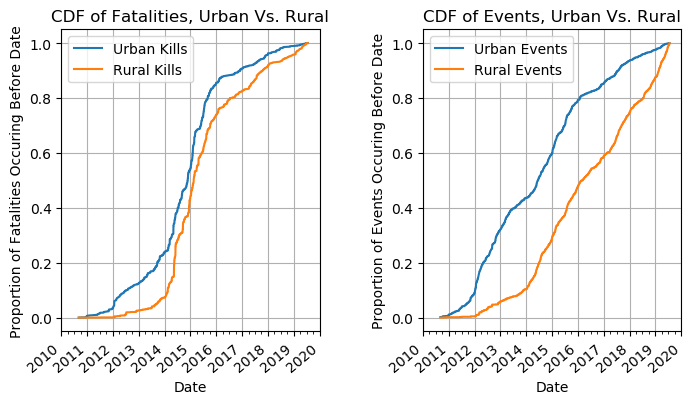

In [19]:
#@title
#Plot all four cumulative distributions

xlabels = range(2010,2021)

fig, ax = plt.subplots(figsize=(8,4), sharey = True, dpi=100)
plt.subplots_adjust(wspace=0.4)

ax1 = plt.subplot(1,2,1)
_ = df_urban.plot(y='nkill_cum_dist', label='Urban Kills', ax=ax1)
_ = df_rural.plot(y='nkill_cum_dist', label='Rural Kills', ax=ax1)
_ = plt.grid()
_ = plt.title('CDF of Fatalities, Urban Vs. Rural')
_ = plt.xlabel('Date')
_ = plt.ylabel('Proportion of Fatalities Occuring Before Date')
_ = ax1.set_xticklabels(xlabels, rotation=40, ha='right')
_ = plt.xlim(('2010-01-01', '2020-01-01'))

ax2 = plt.subplot(1,2,2)
_ = df_urban.plot(y='events_cum_dist', label='Urban Events', ax=ax2)
_ = df_rural.plot(y='events_cum_dist', label='Rural Events', ax=ax2)
_ = plt.grid()
_ = plt.title('CDF of Events, Urban Vs. Rural')
_ = plt.xlabel('Date')
_ = plt.ylabel('Proportion of Events Occuring Before Date')
_ = ax2.set_xticklabels(xlabels, rotation=40, ha='right')
_ = plt.xlim(('2010-01-01', '2020-01-01'))

plt.show()




We can note straight away that all curves show a marked increase in gradient around 2014, and all but 'Rural Events' show a decrease in gradient around 2016. 'Rural Events' is very linear post 2014. I will fit a piecewise linear function to these curves to determine breaking points which are apparent in the curves for fatalities in particular. It is clear for both fatalities curves the appropriate number of break points is 3 as with the overall curve, for the other two we'll do some experimentation again. 

In [20]:
my_pwlf = pwlf.PiecewiseLinFit(df_urban.reset_index().index, df_urban.nkill_cum) #Fit and get break points for the cumulative curve
breaks_urban = my_pwlf.fit(3)
gradients_urban_nkill = np.array([(my_pwlf.predict(breaks_urban[1]) - my_pwlf.predict(breaks_urban[0]))/(breaks_urban[1] - breaks_urban[0]),
                                 (my_pwlf.predict(breaks_urban[2]) - my_pwlf.predict(breaks_urban[1]))/(breaks_urban[2] - breaks_urban[1]),
                                 (my_pwlf.predict(breaks_urban[3]) - my_pwlf.predict(breaks_urban[2]))/(breaks_urban[3] - breaks_urban[2]),])

my_pwlf = pwlf.PiecewiseLinFit(df_rural.reset_index().index, df_rural.nkill_cum)
breaks_rural = my_pwlf.fit(3)
gradients_rural_nkill = np.array([(my_pwlf.predict(breaks_rural[1]) - my_pwlf.predict(breaks_rural[0]))/(breaks_rural[1] - breaks_rural[0]),
                                 (my_pwlf.predict(breaks_rural[2]) - my_pwlf.predict(breaks_rural[1]))/(breaks_rural[2] - breaks_rural[1]),
                                 (my_pwlf.predict(breaks_rural[3]) - my_pwlf.predict(breaks_rural[2]))/(breaks_rural[3] - breaks_rural[2]),])

gradients_nkill = pd.DataFrame({'Urban Gradients': gradients_urban_nkill.reshape(3),
                              'Rural Gradients': gradients_rural_nkill.reshape(3)},
                            index = ['Piece 1', 'Piece 2', 'Piece 3'])

breaks_urban_date =  df_urban.reset_index().loc[np.round(breaks_urban),['index']]
breaks_rural_date =  df_rural.reset_index().loc[np.round(breaks_rural),['index']]
break_points = pd.concat([pd.Series(breaks_urban_date.values.reshape(len(breaks_urban_date)), name = 'Urban Breaks'),
                         pd.Series(breaks_rural_date.values.reshape(len(breaks_rural_date)), name = 'Rural Breaks')], axis = 1)

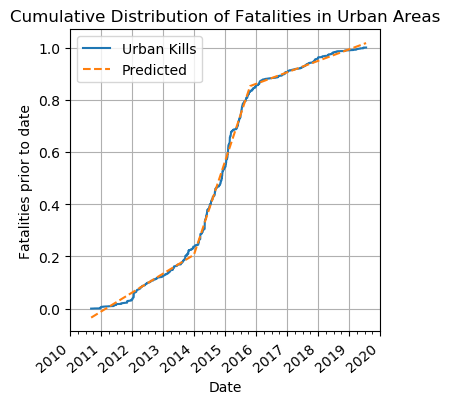

In [21]:
#@title
#Fitting peicewise linear function to cumulative distribution function of nkill in urban areas

my_pwlf = pwlf.PiecewiseLinFit(df_urban.reset_index().index, df_urban.nkill_cum_dist)
breaks_urban = my_pwlf.fit(3)
breaks_urban_nkill = df_urban.reset_index().loc[np.round(breaks_urban),['index']] #This gives us the estimate of the breakpoints

x = df_urban.index.values #x is the dates
df_urban['predicted'] = my_pwlf.predict(range(len(x))) #y is the prediction

fig, ax = plt.subplots(figsize=(4,4), dpi=100)
_ = df_urban.plot(y='nkill_cum_dist', label='Urban Kills', ax=ax)
_ = df_urban.plot(y='predicted', label='Predicted', ax=ax, linestyle='dashed')
_ = plt.legend()
_ = plt.title('Cumulative Distribution of Fatalities in Urban Areas')
_ = plt.xlabel('Date')
_ = plt.ylabel('Fatalities prior to date')
_ = plt.grid()
_ = ax.set_xticklabels(xlabels, rotation=40, ha='right')
_ = plt.xlim(('2010-01-01', '2020-01-01'))

plt.show()

In [ ]:
#@title
my_pwlf.p_values(), my_pwlf.r_squared(), my_pwlf.se #These statistics show that this linear model fits extremely well

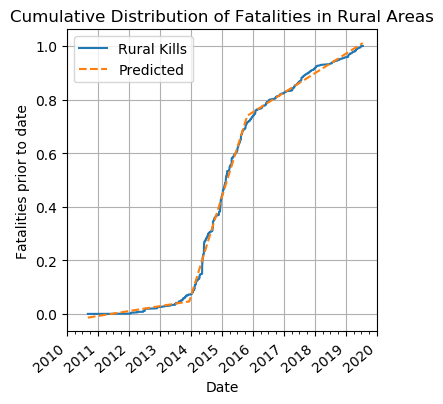

In [22]:
#@title
#Fitting peicewise linear function to cumulative distribution function of nkill in rural areas

my_pwlf = pwlf.PiecewiseLinFit(df_rural.reset_index().index, df_rural.nkill_cum_dist)
breaks_rural = my_pwlf.fit(3)
breaks_rural_nkill = df_urban.reset_index().loc[np.round(breaks_rural),['index']] #This gives us the estimate of the breakpoints

x = df_rural.index.values #x is the dates
df_rural['predicted'] = my_pwlf.predict(range(len(x))) #y is the prediction

fig, ax = plt.subplots(figsize=(4,4), dpi=100)
_ = df_rural.plot(y='nkill_cum_dist', label='Rural Kills', ax=ax)
_ = df_rural.plot(y='predicted', label='Predicted', ax=ax, linestyle='dashed')
_ = plt.legend()
_ = plt.title('Cumulative Distribution of Fatalities in Rural Areas')
_ = plt.xlabel('Date')
_ = plt.ylabel('Fatalities prior to date')
_ = plt.grid()
_ = ax.set_xticklabels(xlabels, rotation=40, ha='right')
_ = plt.xlim(('2010-01-01', '2020-01-01'))

plt.show()

In [0]:
#@title
my_pwlf.p_values(), my_pwlf.r_squared() #Again a very good fit

Below we have the dates for the break points in the curves for number of fatalities in both urban and rural areas. We have found that the break points for 'Fatalities' for urban and rural areas occur within 3 weeks for the first and just a few days for the second which lends some weight to the probability that something occured across the board which caused Boko Haram to change their behaviour at these times.

In [38]:
#@title
break_points

,Urban Breaks,Rural Breaks
0,2010-09-05,2010-09-05
1,2013-12-29,2013-12-12
2,2015-10-21,2015-10-25
3,2019-07-19,2019-07-19


In order to compare the behaviour of the curves for Urban and Rural in the regions pre-2014 and post-2016 we will look at the gradients of the cumulative curves in these regions. Here gradient refers to the steepness of the curve at a certain point. This is estimated by fitting the piecewise linear function to the curve and taking the gradients of the lines. In this case specifically, the gradient measures the number of fatalities/events per day. To compare the gradients of the curves for Urban and Rural areas we should use the cumulative sum, not the cumulative distribution, so let's do that.

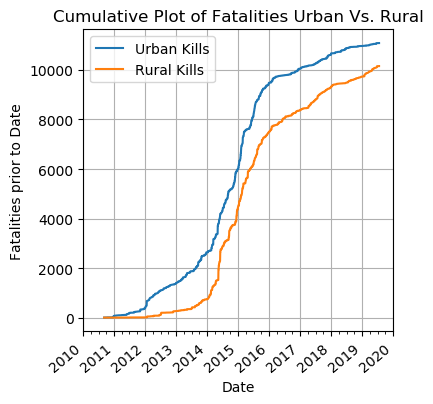

In [23]:
#@title
fig, ax = plt.subplots(figsize=(4,4), dpi=100)

_ = df_urban.plot(y='nkill_cum', label='Urban Kills', ax=ax)
_ = df_rural.plot(y='nkill_cum', label='Rural Kills', ax=ax)
_ = plt.title('Cumulative Plot of Fatalities Urban Vs. Rural')
_ = plt.xlabel('Date')
_ = plt.ylabel('Fatalities prior to Date')
_ = plt.grid()
_ = ax.set_xticklabels(xlabels, rotation=40, ha='right')
_ = plt.xlim(('2010-01-01', '2020-01-01'))

plt.show()

Note: Here Piece 1 refers roughly to the region before 2014, Piece 2 refers to 2014-2016 and Piece 3 is 2016 onwards.

In [39]:
#@title
gradients_nkill

,Urban Gradients,Rural Gradients
Piece 1,2.199055,0.513796
Piece 2,10.829354,10.327389
Piece 3,1.335443,2.024063


The gradients of the piecewise linear function fitted to the curves give estimates for the average rate of increase in the number of fatalities. Here we see that there has been a significant shift in the rate of killing over time from urban to rural areas, though it is true that the rate in urban areas remains reasonably high, and the rural gradient on piece 3 is still less than the urban gradient on piece 1. The above analysis demonstrates that there have been two distinct breaking points and that since the first breaking point Boko Haram have been focussing on rural areas as much as urban ones, where before they were focussing on urban areas largely, and since 2016 they have been focussing significantly more on rural areas.

I now want to run a similar analysis for the number of events.

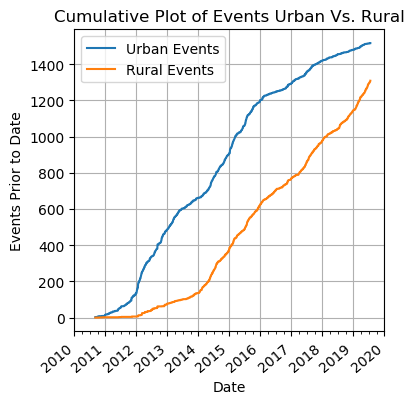

In [24]:
#@title
fig, ax = plt.subplots(figsize=(4,4), dpi=100)

_ = df_urban.plot(y='events_cum', label='Urban Events', ax=ax)
_ = df_rural.plot(y='events_cum', label='Rural Events', ax=ax)
_ = plt.title('Cumulative Plot of Events Urban Vs. Rural')
_ = plt.xlabel('Date')
_ = plt.ylabel('Events Prior to Date')
_ = plt.grid()
_ = ax.set_xticklabels(xlabels, rotation=40, ha='right')
_ = plt.xlim(('2010-01-01', '2020-01-01'))

plt.show()

First we'll fit a function to the curve for urban events. Let's take a look at the r_squared values for different numbers of pieces first.

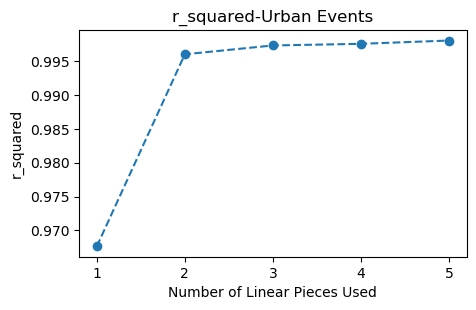

In [27]:
x = np.array(df_urban.reset_index().index).reshape(-1,1)
y = df_urban['events_cum_dist']

linear_model = LinearRegression()
_ = linear_model.fit(x, y)
linear_r_sq = linear_model.score(x, y)

r_squared = [get_r_square(df_urban.events_cum_dist, number_of_lines) for number_of_lines in (2,3,4,5)]

r_squared = np.append(linear_r_sq, r_squared)

#r_squared = [get_r_square(df_urban.events_cum_dist, number_of_lines) for number_of_lines in (2,3,4,5)]

fig, ax = plt.subplots(figsize=(5,3), dpi=100)
_ = plt.plot(np.array([1,2,3,4,5]), r_squared, linestyle='dashed', marker='o')
_ = plt.xticks([1,2,3,4,5])
_ = plt.xlabel('Number of Linear Pieces Used')
_ = plt.ylabel('r_squared')
_ = plt.title('r_squared-Urban Events')

plt.show()

An r_squared value of over 0.99 for 2 linear pieces indicates that this is a good fit and there is almost no gain from increasing this value. Let's take a look at the break points for a few values anyway:

In [30]:
#@title
#Fitting peicewise linear function to cumulative distribution function of events in urban areas, since it's less obvious how many breaks is optimal I will check out 2,3,4 and look at which break points are persistent

my_pwlf = pwlf.PiecewiseLinFit(df_urban.reset_index().index, df_urban.events_cum_dist)

for number_of_lines in (2,3,4):
    print('Break points for '+str(number_of_lines)+' lines:')
    breaks_urban = my_pwlf.fit(number_of_lines)
    breaks_urban_events = df_urban.reset_index().loc[np.round(breaks_urban),['index']] #This gives us the estimates of the breakpoints
    breaks_urban_events.columns = ['Break Points']
    breaks_urban_events

Break points for 2 lines:


,Break Points
0.0,2010-09-05
2033.0,2016-03-30
3239.0,2019-07-19


Break points for 3 lines:


,Break Points
0.0,2010-09-05
259.0,2011-05-22
1996.0,2016-02-22
3239.0,2019-07-19


Break points for 4 lines:


,Break Points
0.0,2010-09-05
428.0,2011-11-07
582.0,2012-04-09
2031.0,2016-03-28
3239.0,2019-07-19


We see that early 2016 is consistently identified as a breaking point. Let's have look at the fitted plot for 2 break points:

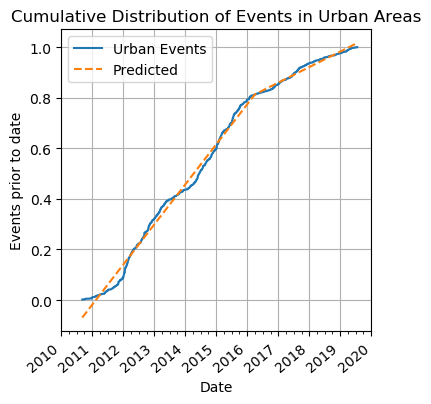

In [31]:
#@title
number_of_lines = 2
breaks_urban = my_pwlf.fit(number_of_lines)
breaks_urban_events = df_urban.reset_index().loc[np.round(breaks_urban),['index']] #This gives us the estimates of the breakpoints
  
x = df_urban.index.values #x is the dates
df_urban['predicted'] = my_pwlf.predict(range(len(x))) #y is the prediction

fig, ax = plt.subplots(figsize=(4,4), dpi=100)
_ = df_urban.plot(y='events_cum_dist', label='Urban Events', ax=ax)
_ = df_urban.plot(y='predicted', label='Predicted', ax=ax, linestyle='dashed')
_ = plt.legend()
_ = plt.title('Cumulative Distribution of Events in Urban Areas')
_ = plt.xlabel('Date')
_ = plt.ylabel('Events prior to date')
_ = plt.grid()
_ = ax.set_xticklabels(xlabels, rotation=40, ha='right')
_ = plt.xlim(('2010-01-01', '2020-01-01'))

plt.show()

In [32]:
table, r_squared = get_regression_table(df_urban, df_urban.events_cum_dist, 2)
table
print(r_squared)

,Dates,p_values,Standard Error
0,2010-09-05,0.0,8.884614e-04
1,2016-03-29,0.0,6.750664e-07
2,2019-07-19,0.0,1.747982e-06


R_squared: 0.9960281231335155


(Plotted curve fitted with 2 lines)

We see here that there is just one particularly persistent break point which occurs in the fitting for every number of pieces, the dates for this break point are 2016-03-29, 2016-02-21, 2016-03-28 so I think it is reasonable to say that there was significant change in the region of late February/March 2016 where the frequency of events significantly slowed in Urban areas. Prior to this point in time the curve is very linear as we see a good fit with just two pieces. This roughly coincides with the marked reduction in the rate of increase in fatalities in both urban and rural areas at the end of 2015, though it is a few months later.

Now on to the curve for rural events.

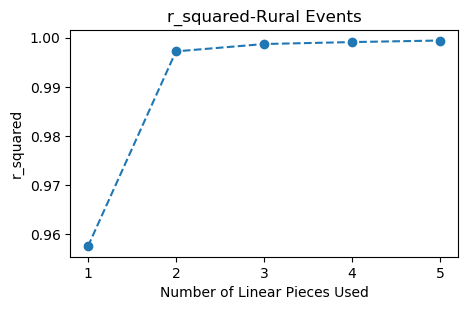

In [33]:
x = np.array(df_rural.reset_index().index).reshape(-1,1)
y = df_rural['events_cum_dist']

linear_model = LinearRegression()
_ = linear_model.fit(x, y)
linear_r_sq = linear_model.score(x, y)

r_squared = [get_r_square(df_rural.events_cum_dist, number_of_lines) for number_of_lines in (2,3,4,5)]

r_squared = np.append(linear_r_sq, r_squared)

#r_squared = [get_r_square(df_rural.events_cum_dist, number_of_lines) for number_of_lines in (2,3,4,5)]

fig, ax = plt.subplots(figsize=(5,3), dpi=100)
_ = plt.plot(np.array([1,2,3,4,5]), r_squared, linestyle='dashed', marker='o')
_ = plt.xticks([1,2,3,4,5])
_ = plt.xlabel('Number of Linear Pieces Used')
_ = plt.ylabel('r_squared')
_ = plt.title('r_squared-Rural Events')

plt.show()

Again a good fit with just 2 pieces and minimal improvement with more pieces added, but let's take a look at the breakpoints:

In [42]:
#@title
#Fitting peicewise linear function to cumulative distribution function of events in rural areas, since it's less obvious how many breaks is optimal I will check out 2,3,4 and look at which break points are persistent

my_pwlf = pwlf.PiecewiseLinFit(df_rural.reset_index().index, df_rural.events_cum_dist)

for number_of_lines in (2,3,4):
    print('Break points for '+str(number_of_lines)+' lines:')
    breaks_rural = my_pwlf.fit(number_of_lines)
    breaks_rural_events = df_rural.reset_index().loc[np.round(breaks_rural),['index']] #This gives us the estimates of the breakpoints
    breaks_rural_events.columns = ['Break Points']
    breaks_rural_events

Break points for 2 lines:


,Break Points
0.0,2010-09-05
1048.0,2013-07-19
3239.0,2019-07-19


Break points for 3 lines:


,Break Points
0.0,2010-09-05
1176.0,2013-11-24
1802.0,2015-08-12
3239.0,2019-07-19


Break points for 4 lines:


,Break Points
0.0,2010-09-05
1174.0,2013-11-22
1965.0,2016-01-22
2338.0,2017-01-29
3239.0,2019-07-19


We see a breakpoint mid-late 2013.

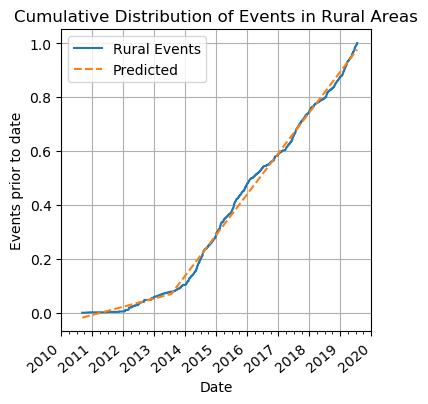

In [85]:
#@title
number_of_lines = 2
breaks_rural = my_pwlf.fit(number_of_lines)
breaks_rural_events = df_rural.reset_index().loc[np.round(breaks_rural),['index']] #This gives us the estimates of the breakpoints
  
x = df_rural.index.values #x is the dates
df_rural['predicted'] = my_pwlf.predict(range(len(x))) #y is the prediction

fig, ax = plt.subplots(figsize=(4,4), dpi=100)
df_rural.plot(y='events_cum_dist', label='Rural Events', ax=ax)
df_rural.plot(y='predicted', label='Predicted', ax=ax, linestyle='dashed')
plt.legend()
plt.title('Cumulative Distribution of Events in Rural Areas')
plt.xlabel('Date')
plt.ylabel('Events prior to date')
plt.grid()
ax.set_xticklabels(xlabels, rotation=40, ha='right')
plt.xlim(('2010-01-01', '2020-01-01'))

plt.show()

In [43]:
table, r_squared = get_regression_table(df_rural, df_rural.events_cum_dist, 2)
table
print(r_squared)

,Dates,p_values,Standard Error
0,2010-09-05,1.499304e-78,0.000938
1,2013-07-19,0.000000e+00,0.000001
2,2019-07-19,0.000000e+00,0.000002


R_squared: 0.9972497874865895


(Plotted curve fitted with 2 lines)

We see here that in rural areas there was a significant increase in the rate of events  around late 2013, with a similar point in time appearing when fitting a curve with three and four pieces at the end of November 2013. After this point the curve is very linear, illustrated by the fact that we get very little gain by fitting more linear pieces to the function. Perhaps whatever caused the reduction in frequency of events in urban areas in 2016 did not affect rural areas in quite the same way.

Since the break points when using both 3 and 4 lines agree on a break point occuring in late November 2013 this is likely a significant point in time. This increase in the rate of events in rural areas occurs just one month before the marked increase in the number of fatalities in both urban and rural areas. This is not, however, a notable point in time for the cumulative distribution of the number of events in urban areas.

The only other thing to note is the appearance of 2015-08-12 and 2016-01-19 as break points for the number of events occuring in rural areas, at which point the occurences of events appear to slow slightly. This occurs shortly before the previously remarked decrease in frequency of events in Feb/March 2016 in urban areas. This also occurs shortly after the break point identifed in the number of fatalities in both urban and rural areas. 

The fact that we find break points that lie so close to one another lends some weight to the hypothesis that something caused large change in the behaviour of Boko Haram.

To further illustrate the differences in both number of fatalities and number of events in urban and rural areas let's actually plot the differences.

In [34]:
compare_nkill = pd.concat([df_urban['nkill_cum'].rename('nkill_cum_urban'), df_rural['nkill_cum'].rename('nkill_cum_rural')], axis = 1)
compare_events = pd.concat([df_urban['events_cum'].rename('events_cum_urban'), df_rural['events_cum'].rename('events_cum_rural')], axis = 1)

In [35]:
compare_nkill['difference'] = compare_nkill['nkill_cum_urban'] - compare_nkill['nkill_cum_rural']
compare_events['difference'] = compare_events['events_cum_urban'] - compare_events['events_cum_rural']

In [36]:
compare_nkill['date'] = compare_nkill.index
compare_events['date'] = compare_events.index

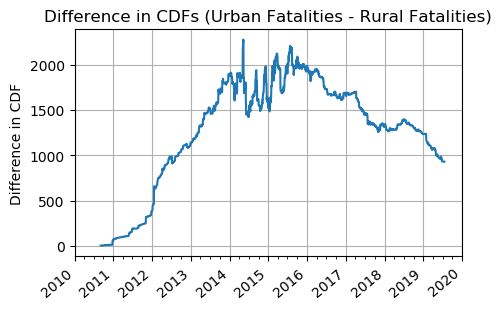

In [38]:
fig, ax = plt.subplots(figsize=(5,3), dpi=100)

_ = compare_nkill['difference'].plot()
_ = plt.title('Difference in CDFs (Urban Fatalities - Rural Fatalities)')
_ = plt.ylabel('Difference in CDF')
_ = ax.set_xticklabels(xlabels, rotation=40, ha='right')
_ = plt.xlim(('2010-01-01', '2020-01-01'))
_ = plt.grid()

plt.show()

Let's fit a piecewise linear function to this curve to see the trends.

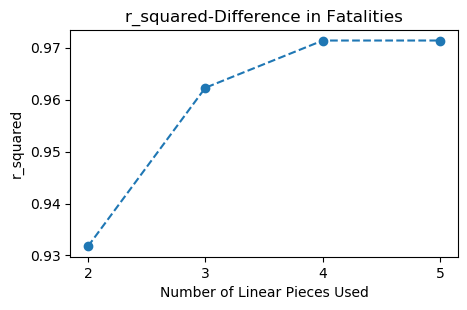

In [43]:
r_squared = [get_r_square(compare_nkill['difference'], number_of_lines) for number_of_lines in (2,3,4,5)]

fig, ax = plt.subplots(figsize=(5,3), dpi=100)
_ = plt.plot(np.array([2,3,4,5]), r_squared, linestyle='dashed', marker='o')
_ = plt.xticks([2,3,4,5])
_ = plt.xlabel('Number of Linear Pieces Used')
_ = plt.ylabel('r_squared')
_ = plt.title('r_squared-Difference in Fatalities')

plt.show()

We see a good improvement with three pieces and not too much increase after, so we'll go with 3. Let's see the break points and plot:

Break points for 3 Pieces:


,Break Points
0.0,2010-09-05
1158.0,2013-11-06
1880.0,2015-10-29
3239.0,2019-07-19


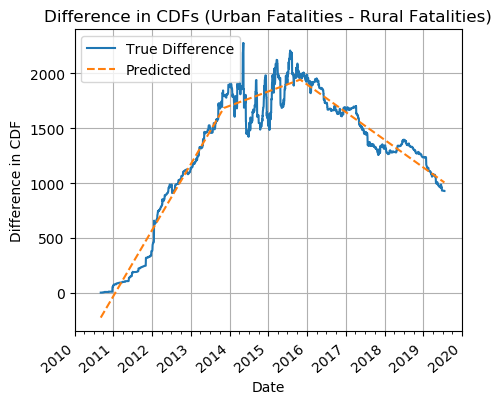

In [44]:
my_pwlf = pwlf.PiecewiseLinFit(compare_nkill['difference'].reset_index().index, compare_nkill['difference'])

print('Break points for 3 Pieces:')
number_of_lines = 3
breaks = my_pwlf.fit(number_of_lines)
breaks_nkill = compare_nkill['difference'].reset_index().loc[np.round(breaks),['index']] #This gives us the estimates of the breakpoints
breaks_nkill.columns = ['Break Points']
breaks_nkill

x = compare_nkill['difference'].index.values #x is the dates
compare_nkill['predicted'] = my_pwlf.predict(range(len(x))) #y is the prediction

fig, ax = plt.subplots(figsize=(5,4), dpi=100)
_ = compare_nkill.plot(y='difference', label='True Difference', ax=ax)
_ = compare_nkill.plot(y='predicted', label='Predicted', ax=ax, linestyle='dashed')
_ = plt.legend()
_ = plt.title('Difference in CDFs (Urban Fatalities - Rural Fatalities)')
_ = plt.xlabel('Date')
_ = plt.ylabel('Difference in CDF')
_ = ax.set_xticklabels(xlabels, rotation=40, ha='right')
_ = plt.xlim(('2010-01-01', '2020-01-01'))
_ = plt.grid()

plt.show()

This picture tells us more or less what we could see from previous analysis:


*   2010-2014: Urban fatalities occuring much faster than Rural fatalities
*   2014-2016: The difference closes somewhat with urban still edging ahead
*   2016-2019: Rural fatalities start occuring faster than rural fatalities

But we can also have a peak and see when this linear model predicts our curve will hit 0 again:



In [45]:
table, r_squared = get_regression_table(compare_nkill, compare_nkill['difference'], 3)
table
print(r_squared)

,Dates,p_values,Standard Error
0,2010-09-05,2.961174e-237,6.305952
1,2013-11-06,0.000000e+00,0.008230
2,2015-10-29,0.000000e+00,0.017099
3,2019-07-19,0.000000e+00,0.015663


R_squared: 0.9622938802004559


In [89]:
x1 = breaks_nkill.index[2]
y1 = my_pwlf.predict(x1)
x2 = breaks_nkill.index[3]
y2 = my_pwlf.predict(x2)
m = (y2-y1)/(x2-x1)
root = x1 - y1/m
date_range = pd.date_range('2010-09-05', '2040-07-19')
root_date = date_range.values[int(np.round(root[0]))]
print(str(root_date)[:10])

2023-07-16


This linear model predicts that at this rate rural fatalities will overtake urban fatalities by 16/07/2023

Now let's see if the curve for the difference in the cumulative number of events has anything to say.

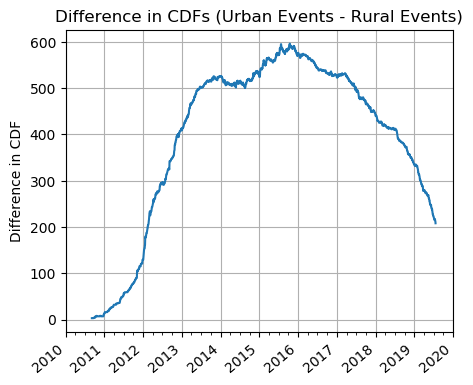

In [90]:
fig, ax = plt.subplots(figsize=(5,4), dpi=100)

_ = compare_events['difference'].plot()
_ = plt.title('Difference in CDFs (Urban Events - Rural Events)')
_ = plt.ylabel('Difference in CDF')
_ = ax.set_xticklabels(xlabels, rotation=40, ha='right')
_ = plt.xlim(('2010-01-01', '2020-01-01'))
_ = plt.grid()

plt.show()

Break points for 3 Pieces:


,Break Points
0.0,2010-09-05
1039.0,2013-07-10
2146.0,2016-07-21
3239.0,2019-07-19


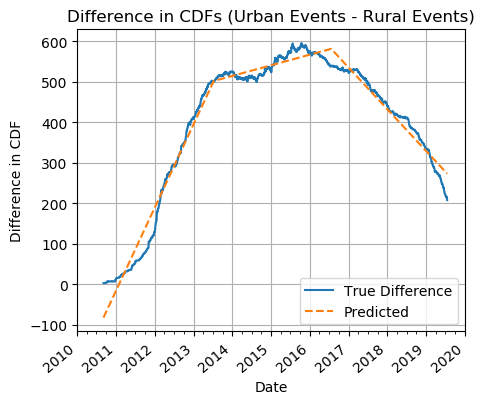

In [46]:
my_pwlf = pwlf.PiecewiseLinFit(compare_events['difference'].reset_index().index, compare_events['difference'])

print('Break points for 3 Pieces:')
number_of_lines = 3
breaks = my_pwlf.fit(number_of_lines)
breaks_events = compare_events['difference'].reset_index().loc[np.round(breaks),['index']] #This gives us the estimates of the breakpoints
breaks_events.columns = ['Break Points']
breaks_events

x = compare_events['difference'].index.values #x is the dates
compare_events['predicted'] = my_pwlf.predict(range(len(x))) #y is the prediction

fig, ax = plt.subplots(figsize=(5,4), dpi=100)
_ = compare_events.plot(y='difference', label='True Difference', ax=ax)
_ = compare_events.plot(y='predicted', label='Predicted', ax=ax, linestyle='dashed')
_ = plt.legend()
_ = plt.title('Difference in CDFs (Urban Events - Rural Events)')
_ = plt.xlabel('Date')
_ = plt.ylabel('Difference in CDF')
_ = ax.set_xticklabels(xlabels, rotation=40, ha='right')
_ = plt.xlim(('2010-01-01', '2020-01-01'))
_ = plt.grid()

plt.show()

In [47]:
table, r_squared = get_regression_table(compare_events, compare_events['difference'], 3)
table
print(r_squared)

,Dates,p_values,Standard Error
0,2010-09-05,0.0,1.410457
1,2013-07-10,0.0,0.001942
2,2016-07-21,0.0,0.003071
3,2019-07-19,0.0,0.002955


R_squared: 0.9808813287622986


In [99]:
x1 = breaks_events.index[2]
y1 = my_pwlf.predict(x1)
x2 = breaks_events.index[3]
y2 = my_pwlf.predict(x2)
m = (y2-y1)/(x2-x1)
root = x1 - y1/m
date_range = pd.date_range('2010-09-05', '2040-07-19')
root_date = date_range.values[int(np.round(root[0]))]
print(str(root_date)[:10])

2022-03-14


It seems there isn't much to add. This model predicts that the number of events in rural areas will overtake those in urban areas by 14/03/2022.